In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, default_collate

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_anomaly_scores, plot_train_hist, plot_anomaly_scores_in_out
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/outputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_out"
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 10
        self.ncomps = 100
        self.profiles = []
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/madgan/' + time_id)
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["madgan", "test", "outputs"]
        self.desc = "All output window test"
        # self.type = "CR1992"
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=False,
    is_train=True,
    scaler=opts.scaler,
    window_size=opts.wsize,
    use_pca=True,
    pca_scaler=MinMaxScaler((-1,1)),
    n_components=opts.ncomps,
    drop_radius=False
)
dataset.filter_profiles(opts.profiles)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Excluding 1179 val files
Window size: 10
Window shape:  torch.Size([10, 100])
First window:
 tensor([[ 1.4407e-01, -2.8773e-01, -7.8421e-01, -7.9571e-02, -4.0906e-01,
         -3.6309e-01, -2.5171e-01, -6.0314e-01, -8.4594e-02, -4.8682e-01,
         -1.4124e-01,  1.0630e-02, -3.6953e-01, -3.0114e-01, -1.6359e-01,
         -1.2133e-01, -3.4170e-01, -9.3157e-02, -5.2654e-02, -1.3141e-01,
         -6.8751e-02, -6.0346e-01, -7.9149e-02, -1.9320e-01, -1.6700e-01,
          5.0210e-03, -1.6773e-01, -1.9362e-02, -3.7559e-01, -2.6266e-02,
         -1.4469e-01, -1.2549e-01, -1.2632e-01, -4.1804e-01, -6.5345e-01,
         -3.2847e-01, -2.1708e-01, -2.0833e-01, -1.0029e-01, -3.1441e-01,
         -2.9404e-01, -1.1643e-01, -1.7964e-01,  1.0018e-02, -1.0935e-01,
         -3.3534e-01, -5.0262e-02, -1.7934e-01, -2.1144e-03, -1.5547e-01,
         -2.0474e-01, -6.0506e-02, -2.0884e-01, -2.4260e-01, -1.4960e-01,
         -4.5240e-01, -3.0576e-01, -4.6562e-01, -2.7840e-01, -4.1491e-01,
         -8.1578e-0

# Models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    nlayers=1,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


In [4]:
netG.train()

Generator(
  (rnn): GRU(100, 200, num_layers=3, batch_first=True)
  (linear): Linear(in_features=200, out_features=100, bias=True)
)

In [5]:
netD.train()

Discriminator(
  (rnn): GRU(100, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [6]:
logger = Logger([netG, netD], opts.model_out / f"{time_id}.md", vars(opts))

runs/madgan/0605-1403


# Training

In [7]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.D_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.G_lr)

In [8]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for [x, _filenames] in tqdm(dataloader, desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.6: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.flatten(fake.detach().cpu().numpy())
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.0237	Loss_G: 22.2352	D(x): 0.9831	D(G(z)): 0.0057


Epoch [1/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.1817	Loss_G: 5.8048	D(x): 0.9816	D(G(z)): 0.0826


Epoch [2/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[2/25]	Loss_D: 0.0938	Loss_G: 9.4488	D(x): 0.9745	D(G(z)): 0.0444


Epoch [3/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[3/25]	Loss_D: 0.1094	Loss_G: 7.7812	D(x): 0.9766	D(G(z)): 0.0608


Epoch [4/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[4/25]	Loss_D: 0.1973	Loss_G: 6.8947	D(x): 0.9632	D(G(z)): 0.0881


Epoch [5/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[5/25]	Loss_D: 0.7892	Loss_G: 20.5841	D(x): 0.9540	D(G(z)): 0.1320


Epoch [6/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[6/25]	Loss_D: 0.7926	Loss_G: 2.0819	D(x): 0.8756	D(G(z)): 0.3432


Epoch [7/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[7/25]	Loss_D: 0.8016	Loss_G: 1.3085	D(x): 0.8725	D(G(z)): 0.4030


Epoch [8/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[8/25]	Loss_D: 1.4880	Loss_G: 0.7234	D(x): 0.8141	D(G(z)): 0.5985


Epoch [9/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.4036	Loss_G: 0.6187	D(x): 0.8255	D(G(z)): 0.5971


Epoch [10/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[10/25]	Loss_D: 0.9352	Loss_G: 0.9878	D(x): 0.8355	D(G(z)): 0.4523


Epoch [11/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.5887	Loss_G: 0.4470	D(x): 0.7587	D(G(z)): 0.6662


Epoch [12/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[12/25]	Loss_D: 1.9626	Loss_G: 0.3294	D(x): 0.7297	D(G(z)): 0.7391


Epoch [13/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.5820	Loss_G: 0.4844	D(x): 0.7265	D(G(z)): 0.6456


Epoch [14/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[14/25]	Loss_D: 1.7323	Loss_G: 0.4331	D(x): 0.7578	D(G(z)): 0.6810


Epoch [15/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[15/25]	Loss_D: 1.8975	Loss_G: 0.3304	D(x): 0.7224	D(G(z)): 0.7342


Epoch [16/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[16/25]	Loss_D: 1.8591	Loss_G: 0.3134	D(x): 0.7209	D(G(z)): 0.7415


Epoch [17/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[17/25]	Loss_D: 2.3515	Loss_G: 0.2491	D(x): 0.6274	D(G(z)): 0.7933


Epoch [18/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[18/25]	Loss_D: 1.6365	Loss_G: 0.4163	D(x): 0.6481	D(G(z)): 0.6695


Epoch [19/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[19/25]	Loss_D: 1.7713	Loss_G: 0.4184	D(x): 0.5955	D(G(z)): 0.6738


Epoch [20/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[20/25]	Loss_D: 1.7649	Loss_G: 0.3874	D(x): 0.6389	D(G(z)): 0.6902


Epoch [21/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[21/25]	Loss_D: 1.8484	Loss_G: 0.4054	D(x): 0.6068	D(G(z)): 0.6857


Epoch [22/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[22/25]	Loss_D: 1.9635	Loss_G: 0.3134	D(x): 0.6062	D(G(z)): 0.7381


Epoch [23/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[23/25]	Loss_D: 1.8004	Loss_G: 0.3832	D(x): 0.6925	D(G(z)): 0.7004


Epoch [24/25]:   0%|          | 0/83 [00:00<?, ?it/s]

[24/25]	Loss_D: 1.9456	Loss_G: 0.3135	D(x): 0.6673	D(G(z)): 0.7446


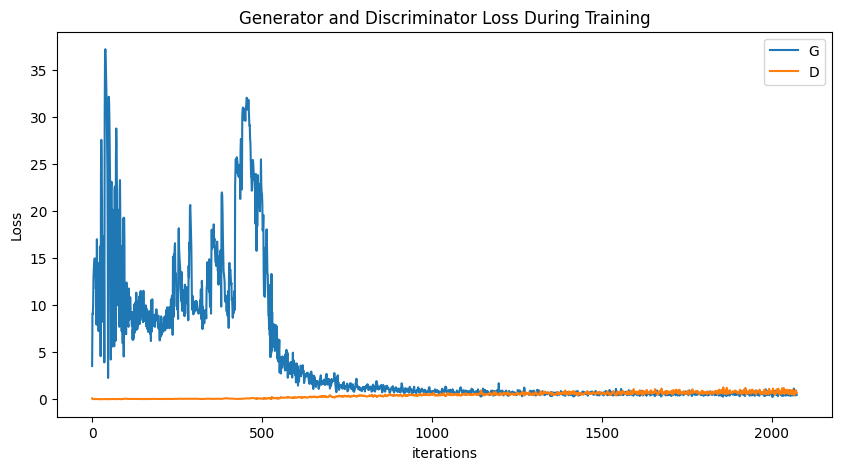

In [9]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [10]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [11]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [12]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [23]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("runs/madgan/0322-1636")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
    data_compiled=Path("../data/compiled")

output_labels = ["n [cm^-3]", "v [km/s]","T [MK]"]  
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [24]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
# eval_dataset.filter_profiles(opts.profiles)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 10
Window shape:  torch.Size([10, 100])
First window:
 tensor([[ 1.4407e-01, -2.8773e-01, -7.8421e-01, -7.9571e-02, -4.0906e-01,
         -3.6309e-01, -2.5171e-01, -6.0314e-01, -8.4594e-02, -4.8682e-01,
         -1.4124e-01,  1.0630e-02, -3.6953e-01, -3.0114e-01, -1.6359e-01,
         -1.2133e-01, -3.4170e-01, -9.3157e-02, -5.2654e-02, -1.3141e-01,
         -6.8751e-02, -6.0346e-01, -7.9149e-02, -1.9320e-01, -1.6700e-01,
          5.0210e-03, -1.6773e-01, -1.9362e-02, -3.7559e-01, -2.6266e-02,
         -1.4469e-01, -1.2549e-01, -1.2632e-01, -4.1804e-01, -6.5345e-01,
         -3.2847e-01, -2.1708e-01, -2.0833e-01, -1.0029e-01, -3.1441e-01,
         -2.9404e-01, -1.1643e-01, -1.7964e-01,  1.0018e-02, -1.0935e-01,
         -3.3534e-01, -5.0262e-02, -1.7934e-01, -2.1144e-03, -1.5547e-01,
         -2.0474e-01, -6.0506e-02, -2.0884e-01, -2.4260e-01, -1.4960e-01,
         -4.5240e-01, -3.0576e-01, -4.6562e-01, -2.7840e-01, -4.1491e-01,
         -8.1578e-02, -6.7548e-02, -2.8055e-

## Discriminator Classification

In [25]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.6849581003189087
Found 352 anomalies


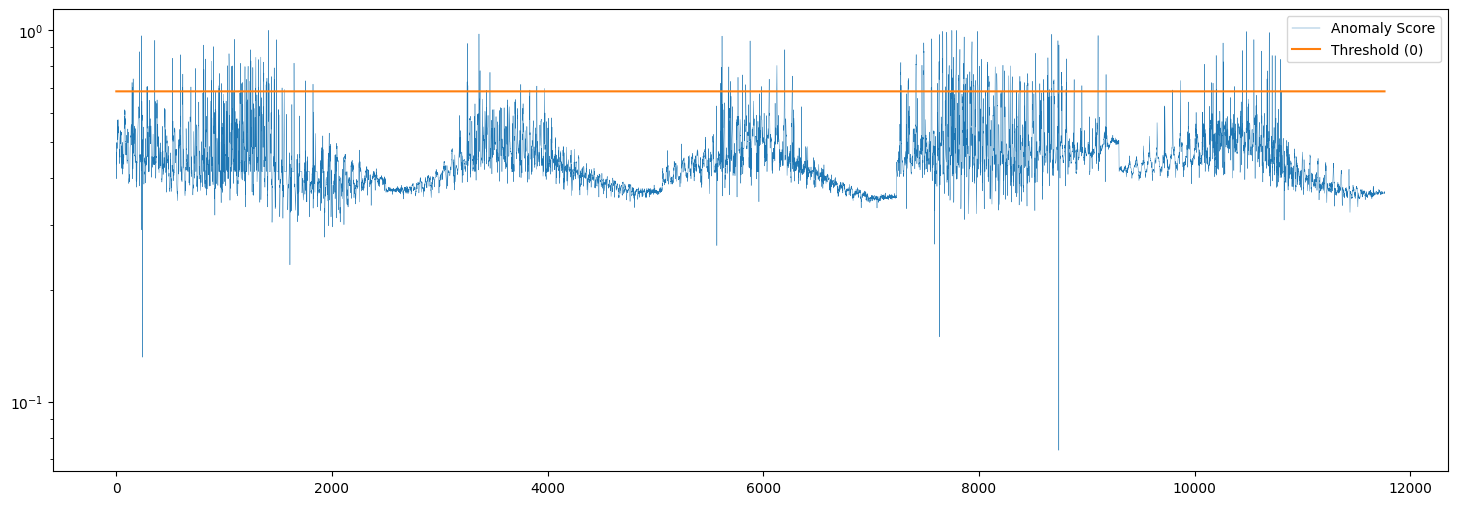

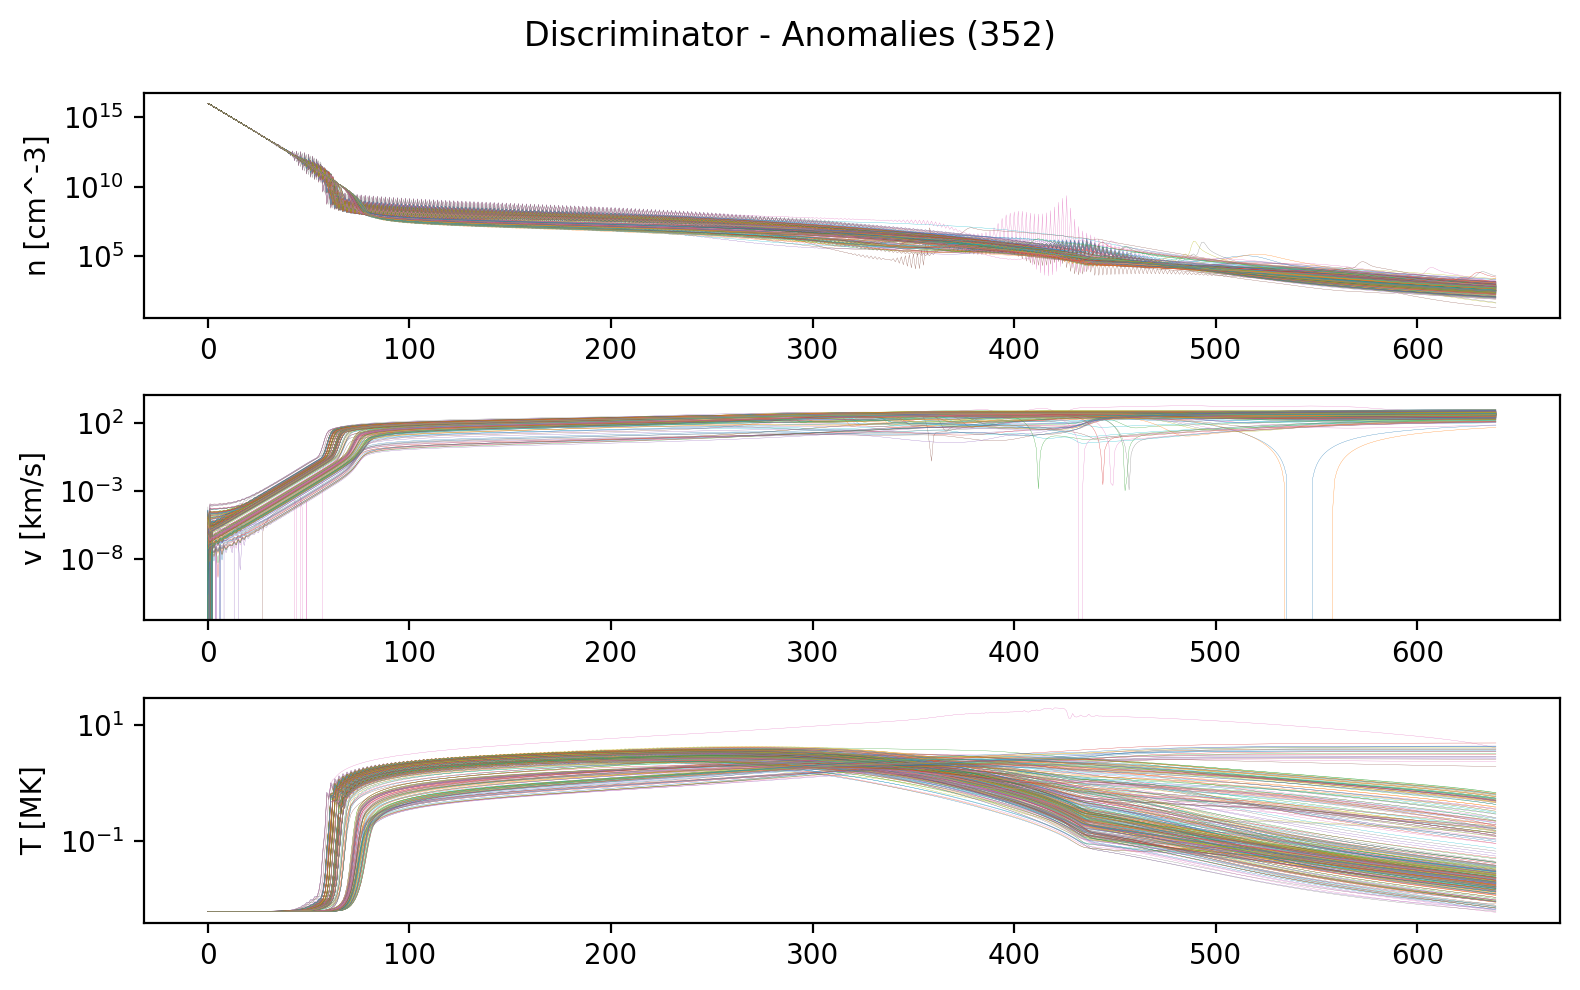

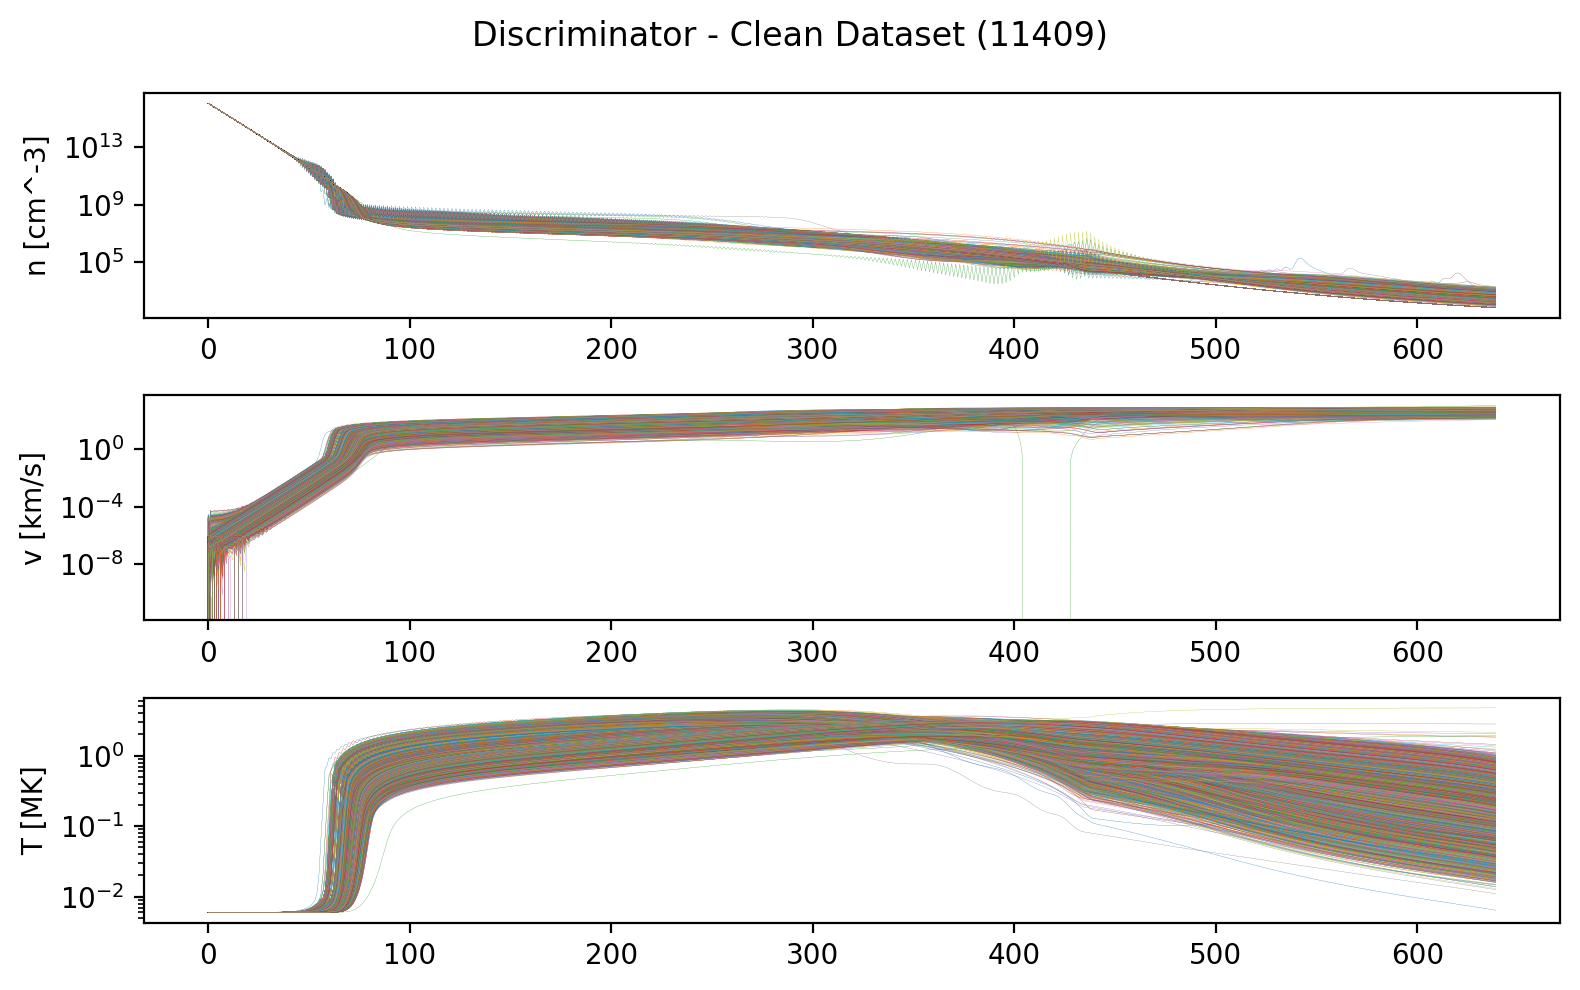

In [26]:
anomalies =\
    plot_anomaly_scores(scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/discr",
                        scale="log", method="Discriminator", normal_plot=True, labels=output_labels)
logger.save_anomalies(anomalies, "discr")

## Reconstruction Based

In [27]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [28]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  2.409132
Found 352 anomalies


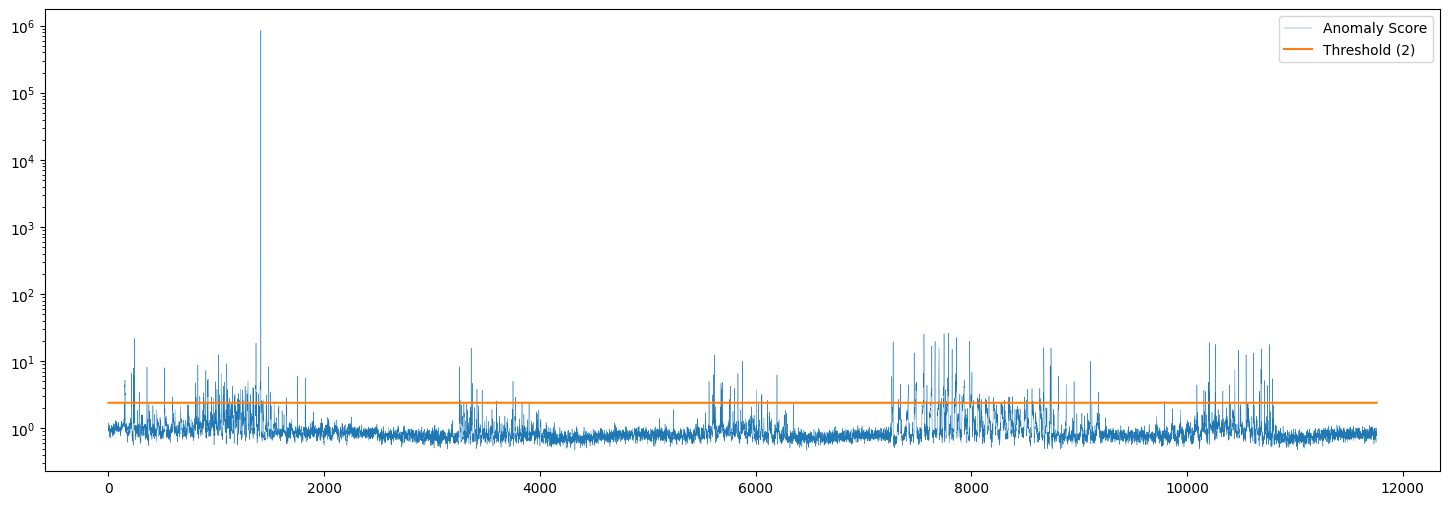

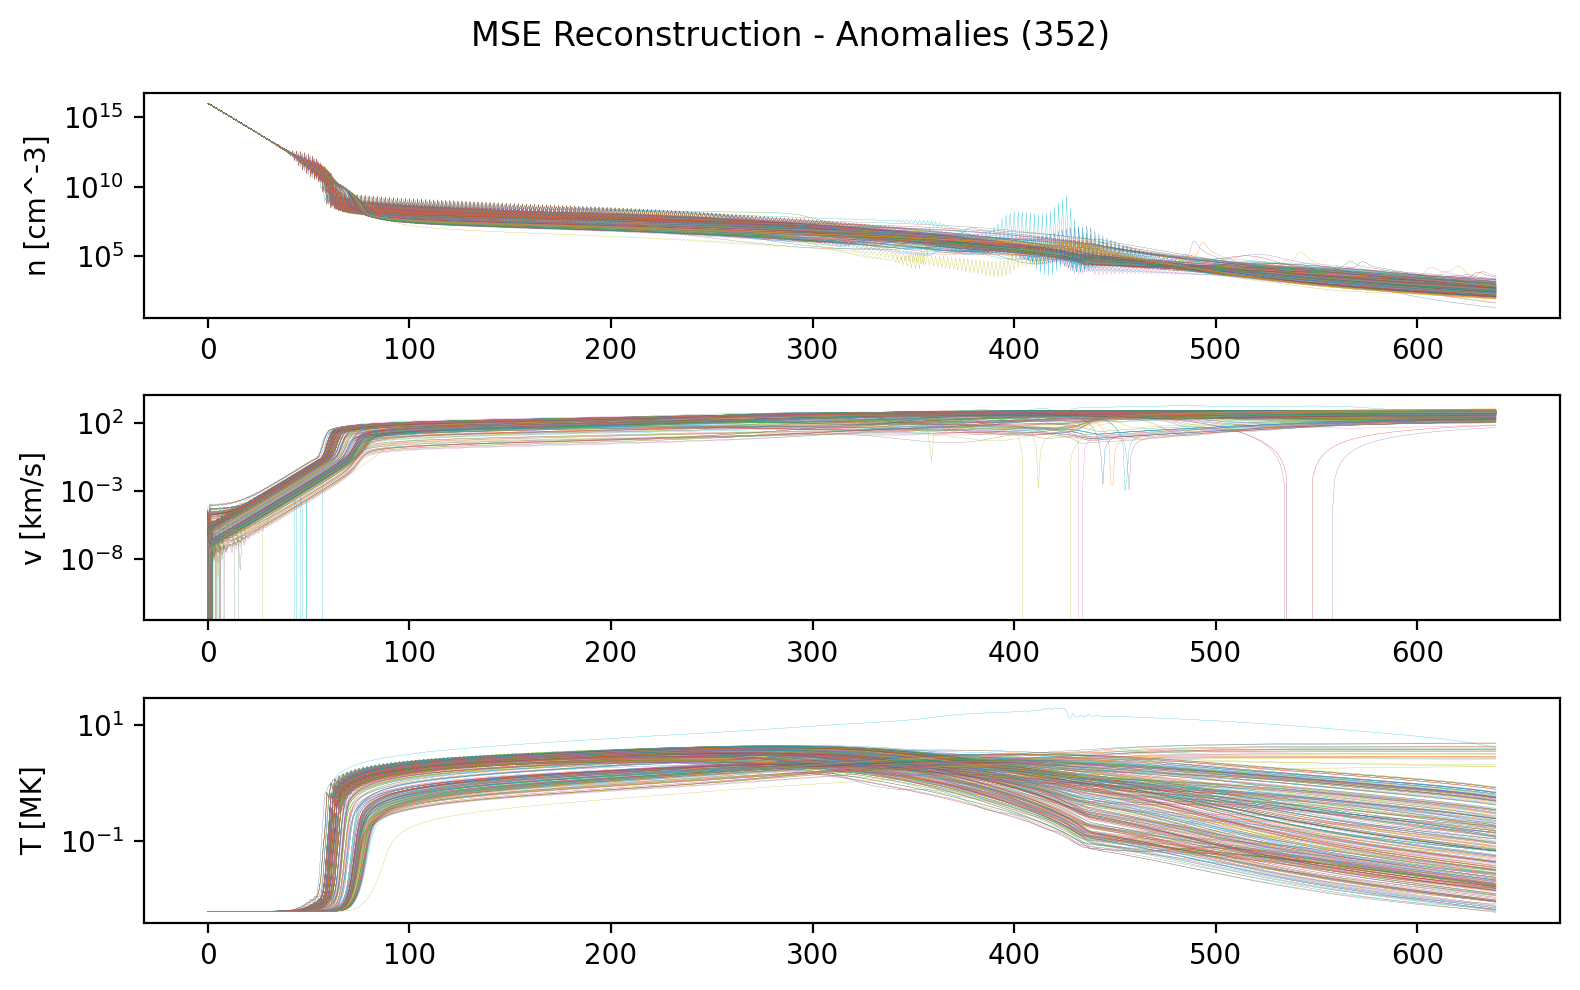

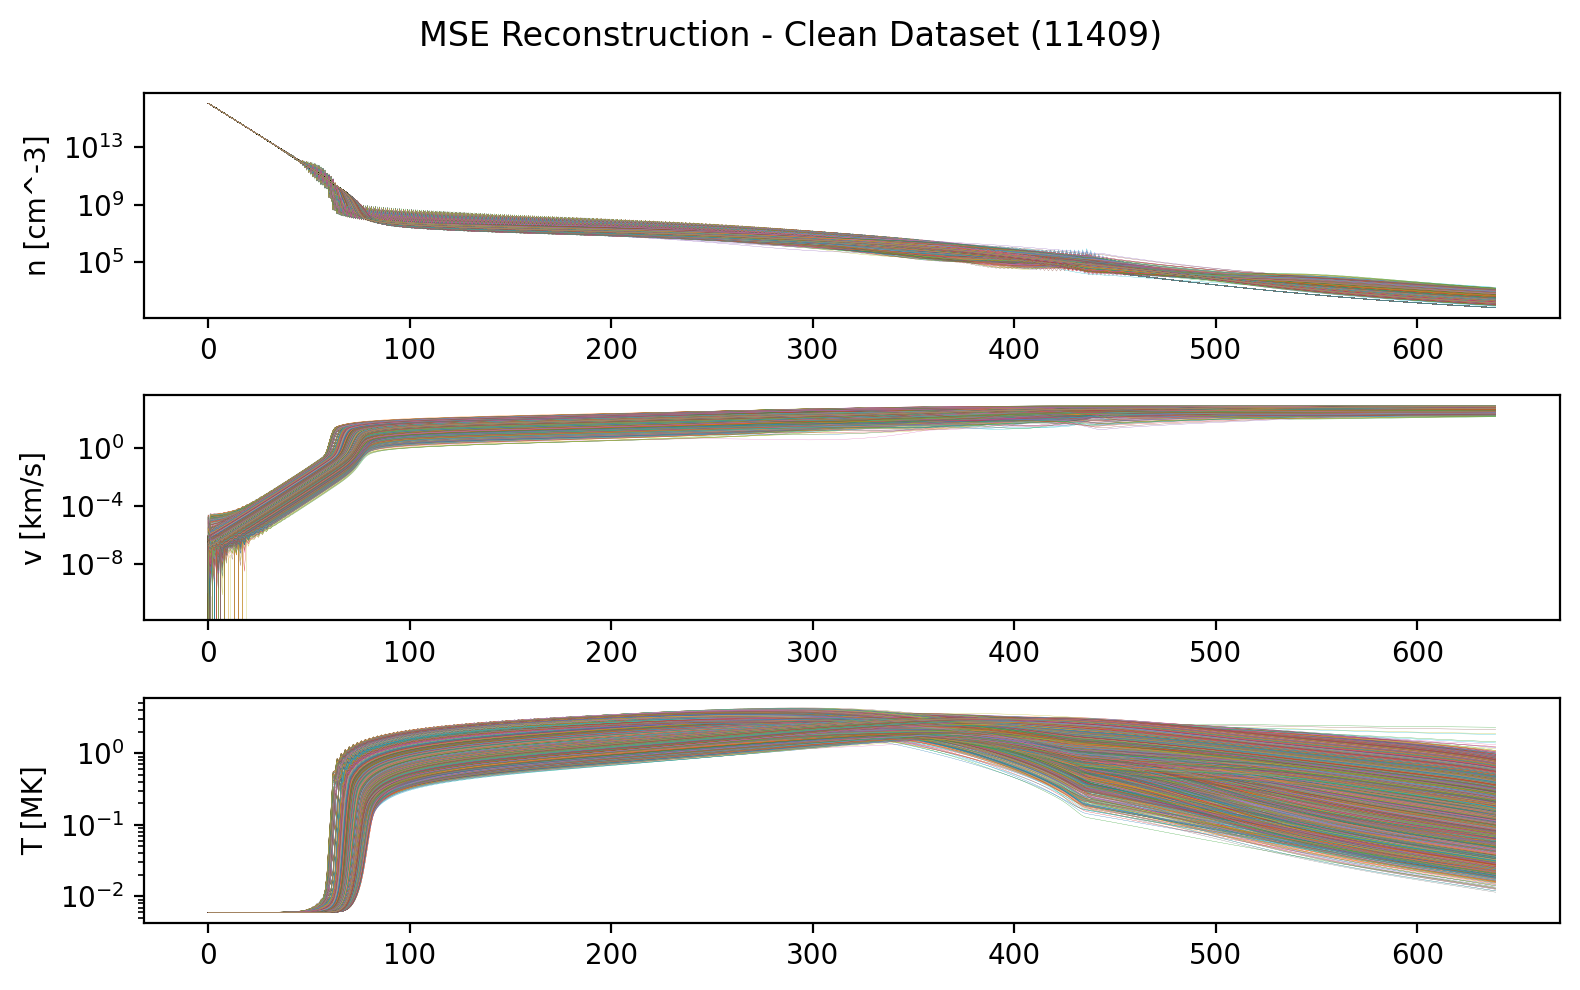

In [29]:
anomalies =\
    plot_anomaly_scores(reconstr_scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE Reconstruction", normal_plot=True, labels=output_labels)
logger.save_anomalies(anomalies, "mse")

### MSE Reconstruction with Discriminator feedback

In [31]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.6920315
Found 352 anomalies


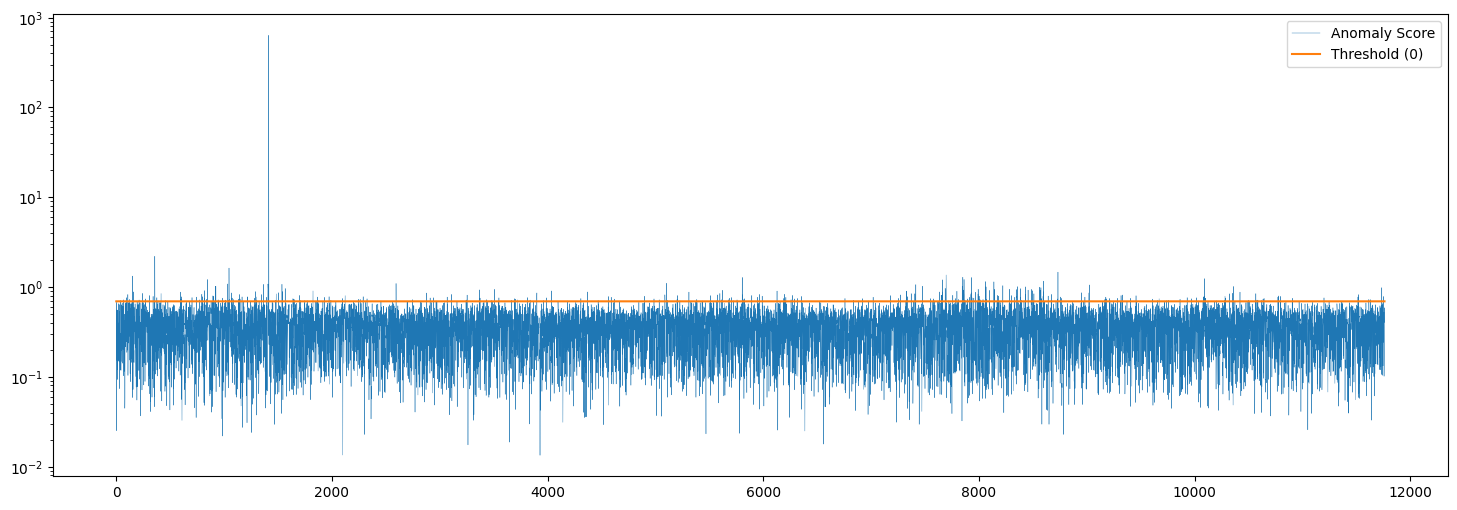

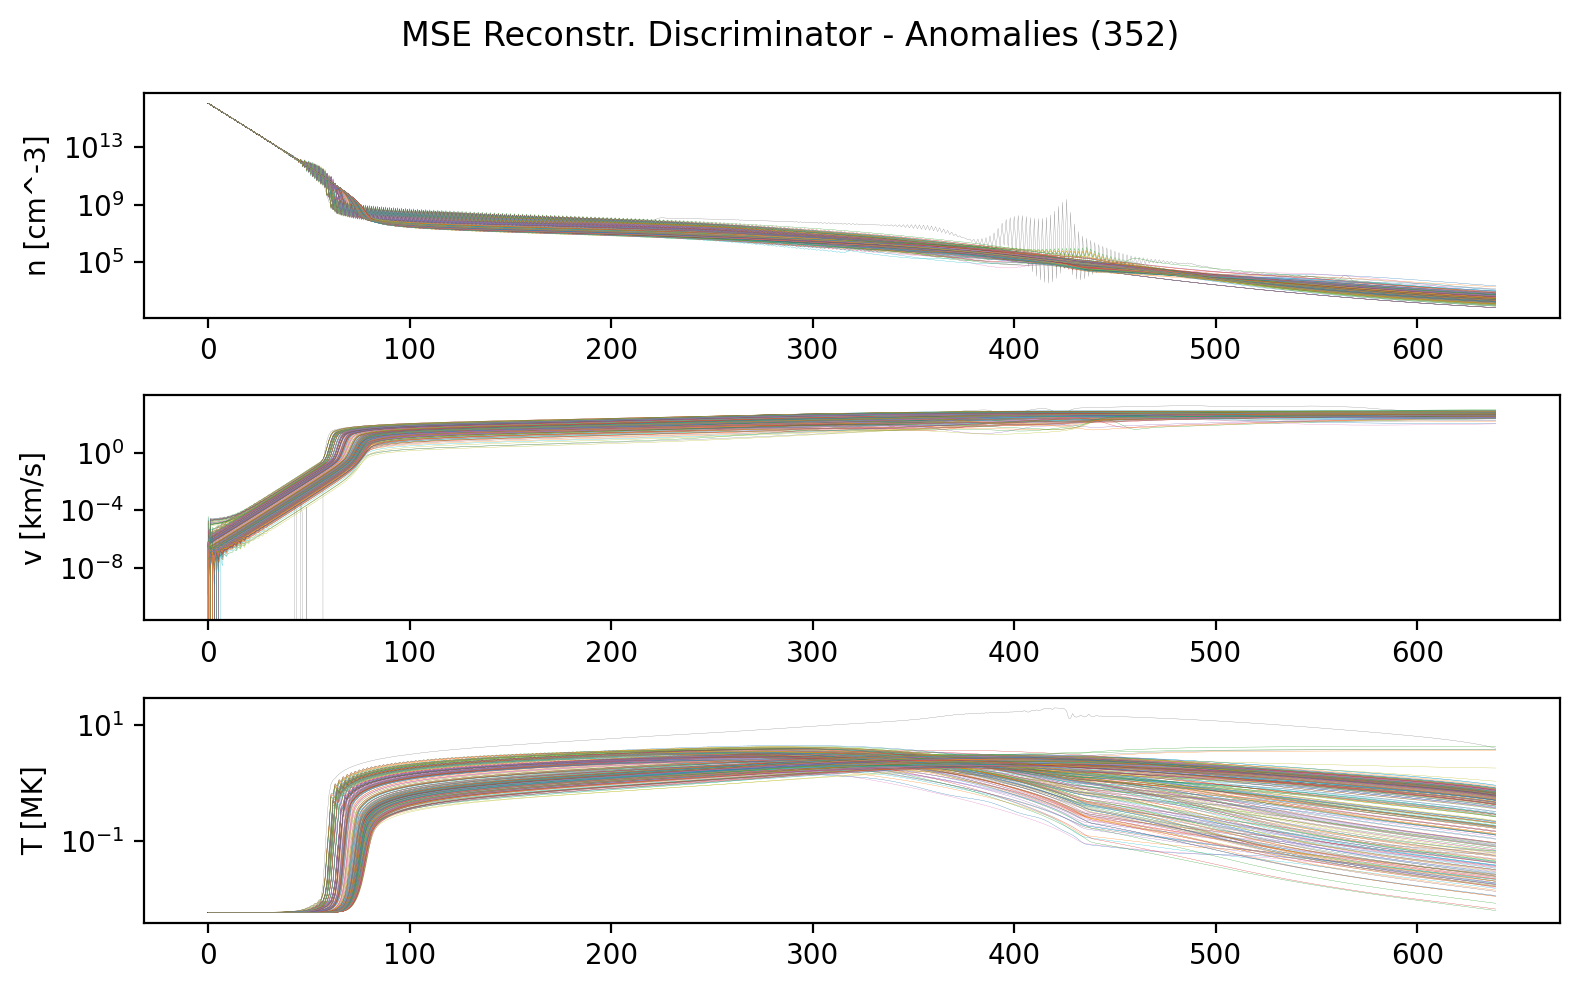

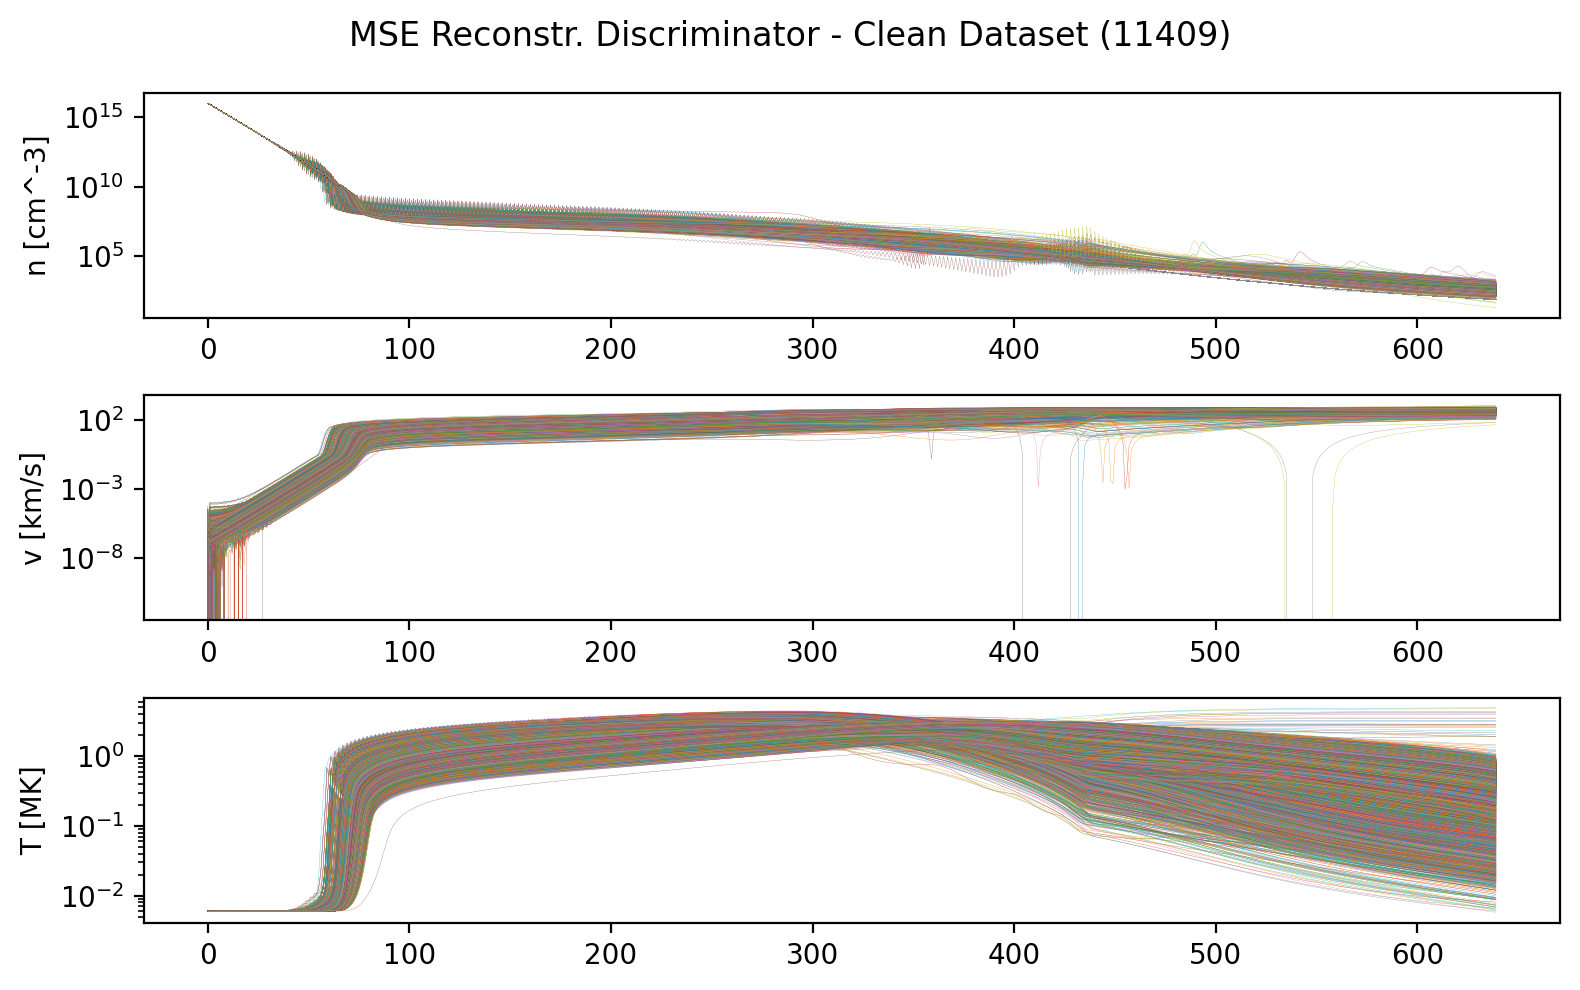

In [32]:
anomalies =\
    plot_anomaly_scores(reconstr_scores_discr, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE Reconstr. Discriminator", normal_plot=True, labels=output_labels)
logger.save_anomalies(anomalies, "mse_discr")